In [11]:
import pandas as pd
from DataPostprocessing.utils import get_mask_from_RLE
import numpy as np 
import matplotlib.pyplot as plt 

path = "../Annotations/OriginalResolution/CANDID-PTX.csv"
df = pd.read_csv(path)

columns = df.columns

print("Dataset: CANDID-PTX")
print("Shape", df.shape)
print(columns)

Dataset: CANDID-PTX
Shape (19235, 9)
Index(['ImageID', 'Dice RCA (Mean)', 'Dice RCA (Max)', 'Landmarks',
       'Left Lung', 'Right Lung', 'Heart', 'Height', 'Width'],
      dtype='object')


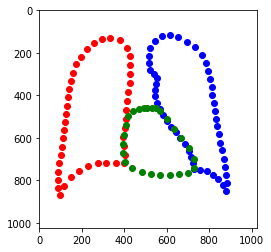

In [16]:
example = df.iloc[0]

landmarks = example["Landmarks"]
height, width = example["Height"], example["Width"]

# As landmarks are stored as a string, we need to convert it to a numpy array
landmarks = eval(landmarks)
landmarks = np.array(landmarks).reshape(-1, 2)

rightLungLandmarks = landmarks[:44, :]
leftLungLandmarks = landmarks[44:94, :]
heartLandmarks = landmarks[94:, :]

plt.figure()

plt.scatter(rightLungLandmarks[:, 0], rightLungLandmarks[:, 1], c = "r")
plt.scatter(leftLungLandmarks[:, 0], leftLungLandmarks[:, 1], c = "b")
plt.scatter(heartLandmarks[:, 0], heartLandmarks[:, 1], c = "g")

plt.xlim(0, width)
plt.ylim(0, height)

plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

Text(0.5, 1.0, 'Heart Mask')

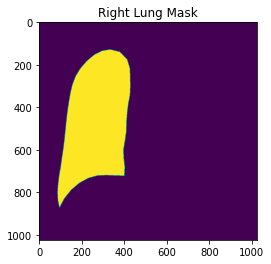

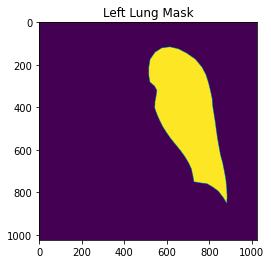

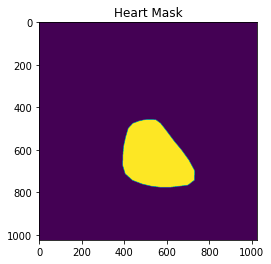

In [15]:
rightLungMask_RLE = example["Right Lung"]
leftLungMask_RLE = example["Left Lung"]
heartMask_RLE = example["Heart"]

rightLungMask = get_mask_from_RLE(rightLungMask_RLE, height, width)
leftLungMask = get_mask_from_RLE(leftLungMask_RLE, height, width)
heartMask = get_mask_from_RLE(heartMask_RLE, height, width)

plt.figure()
plt.imshow(rightLungMask)
plt.title("Right Lung Mask")

plt.figure()
plt.imshow(leftLungMask)
plt.title("Left Lung Mask")

plt.figure()
plt.imshow(heartMask)
plt.title("Heart Mask")

Text(0.5, 1.0, 'Combined Mask')

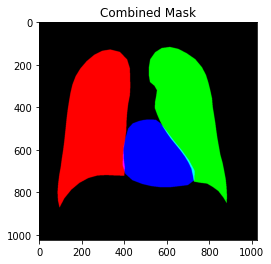

In [17]:
# Combine masks, in different colors

mask = np.zeros([height, width, 3], dtype = np.uint8)
mask[:, :, 0] = rightLungMask
mask[:, :, 1] = leftLungMask
mask[:, :, 2] = heartMask

plt.figure()
plt.imshow(mask)
plt.title("Combined Mask")
plt.show()

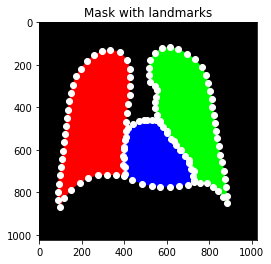

In [20]:
# Combine masks with landmarks

plt.figure()

plt.imshow(mask)
plt.scatter(rightLungLandmarks[:, 0], rightLungLandmarks[:, 1], c = "w")
plt.scatter(leftLungLandmarks[:, 0], leftLungLandmarks[:, 1], c = "w")
plt.scatter(heartLandmarks[:, 0], heartLandmarks[:, 1], c = "w")

plt.title("Mask with landmarks")

plt.show()